In [1]:
import requests
import json
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from shapely.ops import nearest_points
import matplotlib.pyplot as plt

# Prepare dataframe for carpark availability

In [2]:
url = 'https://api.data.gov.sg/v1/transport/carpark-availability'
response = requests.get(url)
data = response.json()
df = json_normalize(data['items'][0]['carpark_data'])
cpInfo_df = pd.DataFrame(columns = ['carpark_number','update_datetime','lot_type','lots_available','total_lots'])
carparkAvailability = pd.DataFrame(columns = ['carpark_number','update_datetime','lot_type','lots_available','total_lots'])

for i in range(len(df)):
    cpInfo_df = json_normalize(df['carpark_info'][i])
    cpInfo_df['carpark_number'] = df['carpark_number'][i]
    cpInfo_df['update_datetime'] = df['update_datetime'][i]
    carparkAvailability = carparkAvailability.append(cpInfo_df, sort = True, ignore_index = False)

carparkAvailability.head()

,carpark_number,lot_type,lots_available,total_lots,update_datetime
0,HE12,C,43,91,2019-12-10T22:08:23
0,HLM,C,438,583,2019-12-10T22:08:18
0,RHM,C,124,322,2019-12-10T22:07:54
0,BM29,C,69,97,2019-12-10T22:07:58
0,Q81,C,55,96,2019-12-10T22:08:10


## Test dataframe on carpark

In [3]:
#variable
carparkNumberIndex = 'TB1'

In [4]:
carparkAvailability.loc[carparkAvailability['carpark_number'] == carparkNumberIndex]

,carpark_number,lot_type,lots_available,total_lots,update_datetime
0,TB1,C,4,58,2019-12-10T22:04:56
1,TB1,Y,0,22,2019-12-10T22:04:56
2,TB1,H,0,1,2019-12-10T22:04:56


# Prepare carpark information

In [5]:
dfCarparkInformation = pd.read_csv("hdb-carpark-information.csv") 

Retrieve x coordinates and y coordinates of current location

In [6]:
myXCoord = dfCarparkInformation.loc[dfCarparkInformation['car_park_no'] == carparkNumberIndex].x_coord
myYCoord = dfCarparkInformation.loc[dfCarparkInformation['car_park_no'] == carparkNumberIndex].y_coord

In [7]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(dfCarparkInformation.x_coord, dfCarparkInformation.y_coord)]
geoDfCarparkInformation = dfCarparkInformation.drop(['x_coord', 'y_coord'], axis=1).copy()
crs = {'init': 'epsg:4326'}
geoDfCarparkInformation = GeoDataFrame(geoDfCarparkInformation, crs=crs, geometry=geometry)

Get map of carpark

In [8]:
# unary union of the gpd2 geomtries 
carparkMapPoints = geoDfCarparkInformation.geometry.unary_union

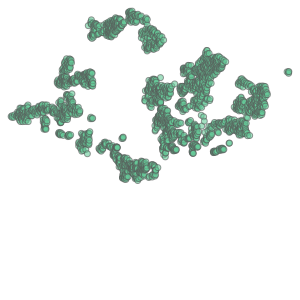

In [9]:
carparkMapPoints

In [10]:
geoDfCarparkInformation['distance'] = geoDfCarparkInformation['geometry'].distance(Point(myXCoord,myYCoord))

In [11]:
nearestCarpark = geoDfCarparkInformation.sort_values(by=['distance'])[0:6].copy()

# get current availability of nearest carpark

In [12]:
 carparkInformationAndAvailability = carparkAvailability.merge(nearestCarpark, left_on='carpark_number', right_on='car_park_no')

In [13]:
carparkInformationAndAvailability

,carpark_number,lot_type,lots_available,total_lots,update_datetime,car_park_no,address,car_park_type,type_of_parking_system,short_term_parking,free_parking,night_parking,car_park_decks,gantry_height,car_park_basement,geometry,distance
0,TB2,C,4,51,2019-12-10T22:08:05,TB2,BLK 8-10 TELOK BLANGAH CRES,SURFACE CAR PARK,ELECTRONIC PARKING,7AM-10.30PM,NO,NO,0,0.00,N,POINT (26444.663 28896.671),126.152770
1,TB2,Y,8,18,2019-12-10T22:08:05,TB2,BLK 8-10 TELOK BLANGAH CRES,SURFACE CAR PARK,ELECTRONIC PARKING,7AM-10.30PM,NO,NO,0,0.00,N,POINT (26444.663 28896.671),126.152770
2,TB2,H,0,1,2019-12-10T22:08:05,TB2,BLK 8-10 TELOK BLANGAH CRES,SURFACE CAR PARK,ELECTRONIC PARKING,7AM-10.30PM,NO,NO,0,0.00,N,POINT (26444.663 28896.671),126.152770
3,TB1,C,4,58,2019-12-10T22:04:56,TB1,BLK 1/2/3/4/6 TELOK BLANGAH CRES,SURFACE CAR PARK,ELECTRONIC PARKING,7AM-10.30PM,NO,NO,0,4.50,N,POINT (26359.053 28989.328),0.000000
4,TB1,Y,0,22,2019-12-10T22:04:56,TB1,BLK 1/2/3/4/6 TELOK BLANGAH CRES,SURFACE CAR PARK,ELECTRONIC PARKING,7AM-10.30PM,NO,NO,0,4.50,N,POINT (26359.053 28989.328),0.000000
5,TB1,H,0,1,2019-12-10T22:04:56,TB1,BLK 1/2/3/4/6 TELOK BLANGAH CRES,SURFACE CAR PARK,ELECTRONIC PARKING,7AM-10.30PM,NO,NO,0,4.50,N,POINT (26359.053 28989.328),0.000000
6,TB3,C,18,154,2019-12-10T22:08:05,TB3,BLK 12/22 TELOK BLANGAH CRES,SURFACE CAR PARK,ELECTRONIC PARKING,WHOLE DAY,NO,YES,0,0.00,N,POINT (26458.504 28811.914),203.387254
7,TB3,Y,2,56,2019-12-10T22:08:05,TB3,BLK 12/22 TELOK BLANGAH CRES,SURFACE CAR PARK,ELECTRONIC PARKING,WHOLE DAY,NO,YES,0,0.00,N,POINT (26458.504 28811.914),203.387254
8,TB3,H,0,1,2019-12-10T22:08:05,TB3,BLK 12/22 TELOK BLANGAH CRES,SURFACE CAR PARK,ELECTRONIC PARKING,WHOLE DAY,NO,YES,0,0.00,N,POINT (26458.504 28811.914),203.387254
9,TBC3,C,51,106,2019-12-10T22:04:56,TBC3,BLK 3A TELOK BLANGAH CRESCENT,MULTI-STOREY CAR PARK,ELECTRONIC PARKING,WHOLE DAY,SUN & PH FR 7AM-10.30PM,YES,8,2.15,N,POINT (26248.219 29055.739),129.206988


In [14]:
carparkAvailability.lot_type.unique()

array(['C', 'Y', 'H', 'L'], dtype=object)

To check what the array maps mean

In [15]:
carparkAvailabilityCleaned = carparkInformationAndAvailability.copy()

In [16]:
carparkAvailabilityCleaned = carparkAvailabilityCleaned.drop(['carpark_number'],axis=1).drop(['update_datetime'],axis=1).drop(['car_park_no'],axis=1).drop(['type_of_parking_system'],axis=1).drop(['night_parking'],axis=1).drop(['car_park_decks'],axis=1).drop(['gantry_height'],axis=1).drop(['car_park_basement'],axis=1).drop(['geometry'],axis=1).drop(['distance'],axis=1).drop('short_term_parking',axis=1).drop('total_lots',axis=1)
carparkAvailabilityCleaned = carparkAvailabilityCleaned[carparkAvailabilityCleaned.lots_available != '0']

In [17]:
carparkAvailabilityResultTotal = carparkAvailabilityCleaned.groupby(['address'])['lots_available'].sum()

In [18]:
out = carparkAvailabilityResultTotal.to_json()

For visualisation

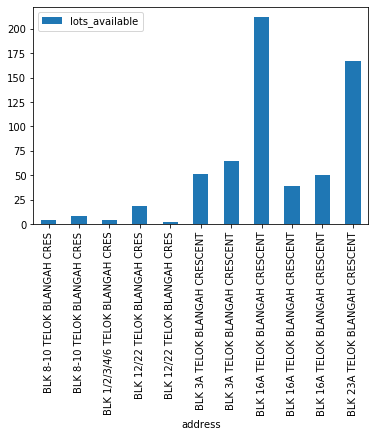

In [19]:
carparkAvailabilityCleaned['lots_available'] = carparkAvailabilityCleaned['lots_available'].astype(int)
carparkAvailabilityCleaned.plot(kind='bar',x='address',y='lots_available')

In [20]:
out

'{"BLK 1\\/2\\/3\\/4\\/6 TELOK BLANGAH CRES":"4","BLK 12\\/22 TELOK BLANGAH CRES":"182","BLK 16A TELOK BLANGAH CRESCENT":"2123950","BLK 23A TELOK BLANGAH CRESCENT":"167","BLK 3A TELOK BLANGAH CRESCENT":"5165","BLK 8-10 TELOK BLANGAH CRES":"48"}'